# Plume Analysis

In [1]:
%matplotlib inline
%reset -f
import fnmatch
import scipy.optimize as sp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os 
import glob
from IPython.display import set_matplotlib_formats
from scipy.optimize import curve_fit
import re
import datetime as dt 
import scipy.signal

# %config InlineBackend.figure_formats = ['svg']
plt.rcParams['savefig.dpi'] = 350
plt.rcParams['figure.figsize'] = [3, 3]
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['lines.markersize'] = 1.
plt.rcParams['figure.dpi'] = 100

In [45]:
def plume_analysis_new(df):
    data_Y=df['Points:1'].values; data_Z=df['Points:2'].values #not height
    dim=int(np.sqrt(len(df['temperature'])))
    T_blocks = np.reshape(df['temperature'].to_numpy(),(dim,dim))
    U_blocks = np.reshape(df['velocity:0'].to_numpy(),(dim,dim))
 
    max_temp=np.max(T_blocks); avg_temp=np.mean(T_blocks); thd_temp=avg_temp+0.2*(max_temp-avg_temp)

    P_blocks=np.zeros((256,256)) #Location of plumes. 1 = plume, 0 = no plume
    T_p_blocks=np.zeros((256,256)) #Only plume temperature. 1 = plume, 0 = no plume

    da=(data_Y[1]-data_Y[0])**2 #area

    pmf=0; phf=0; plume_temp=[]; plume_cells=0; 

    for i in range(dim-1):
        for j in range(dim-1):
            if (T_blocks[i,j]>=thd_temp) and (U_blocks[i,j]>0):
                plume_cells+=1
                plume_temp.append(T_blocks[i,j])
                P_blocks[i,j]=1
                T_p_blocks[i,j]=T_blocks[i,j]
                pmf+=U_blocks[i,j]*da
                phf+=U_blocks[i,j]*(T_blocks[i,j]-avg_temp)*da

    plume_temp_2=np.sum(plume_temp)/plume_cells
    dT = plume_temp_2-avg_temp
    return phf, dT

In [61]:
ra_path = '1e9'; plume_path = '\\Plume Data'
main_path = 'C:\\Users\\super\\Dropbox\\Rice University\\501\\BL_Interactions\\'

fname = os.path.join(main_path+ra_path+plume_path,'[!m]*.csv')
fileL = glob.glob(fname) #list of files
temp = []
for file in fileL:
    a = fileL.index(file)
    b = pd.read_csv(file)
    b.rename(columns={0:a}, inplace=True)
    temp.append(b)

Data = pd.concat(temp, axis=0, join="inner",ignore_index=True)

lenZ = len(fileL)

zUnique = Data['Points:0'].unique()

data = [[] for i in range(lenZ)] #empty nested list

for i in range(lenZ):
    data[i] = Data.loc[Data['Points:0'] == zUnique[i]]
    data[i] = data[i].reset_index(drop=True)
    
plumeData = pd.DataFrame(columns=['Ra', 'Z', 'Q_p', 'dT_p'],
                  index=range(0, lenZ))

plumeData['Ra'] = int(float(ra_path))

for i in range(lenZ):
    pa = plume_analysis_new(data[i])
    plumeData.at[i, 'Z'] = zUnique[i]
    plumeData.at[i, 'Q_p'] = pa[0]
    plumeData.at[i, 'dT_p'] = pa[1]

plumeData = plumeData.sort_values(by=['Z'])
plumeData = plumeData.reset_index(drop=True) 
plumeData

,Ra,Z,Q_p,dT_p
0,1000000000,0.05,120.712508,0.221912
1,1000000000,0.1,122.06375,0.212311
2,1000000000,0.15,106.783092,0.197352
3,1000000000,0.2,93.694516,0.183441
4,1000000000,0.25,85.627401,0.186465
...,...,...,...,...
59,1000000000,0.975,47.480934,0.097453
60,1000000000,0.98,45.02863,0.088538
61,1000000000,0.985,40.322283,0.08822
62,1000000000,0.99,33.842167,0.089523


Get the plume temperatures, mean and standard deviation.
Plot Ra in x, mean plume temp in y with std dev error bars or with  min and max

Try to dimensionalize them

In [62]:
save_path = 'C:\\Users\\super\\Dropbox\\Rice University\\501\\BL_Interactions_Data\\'
Data=pd.read_csv(save_path+'data_short.csv')
data_select = Data.loc[Data['Ra']==plumeData.at[0, 'Ra']]
data_select = data_select.reset_index(drop=True)
nut = data_select.at[0, 'NuT']

Text(0.5, 0, 'Plume Heat Flux')

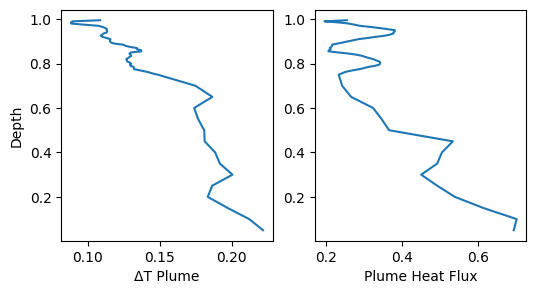

In [63]:
plt.figure(figsize=(6,3))

plt.subplot(1, 2, 1)
plt.plot(plumeData['dT_p'],plumeData['Z'])
plt.xlabel(u'ΔT Plume')
plt.ylabel('Depth')

plt.subplot(1, 2, 2)
plt.plot(plumeData['Q_p']/nut,plumeData['Z'])
plt.xlabel('Plume Heat Flux')

In [ ]:
np.savetxt(main_path+ra_path+'\\Plume Profiles\\Depth.txt',plumeData['Z'])
np.savetxt(main_path+ra_path+'\\Plume Profiles\\Delta_T_Plume.txt',plumeData['dT_p'])
np.savetxt(main_path+ra_path+'\\Plume Profiles\\Plume_Heat_Flux.txt',plumeData['Q_p']/nut)

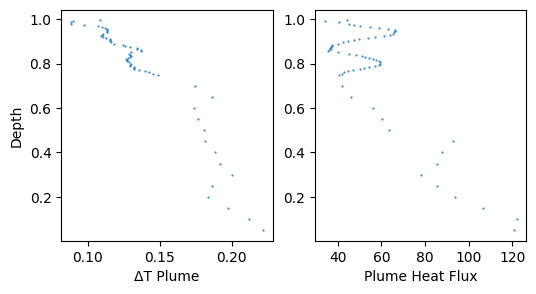

In [65]:
plt.figure(figsize=(6,3))

plt.subplot(1, 2, 1)
plt.plot(plumeData['dT_p'],plumeData['Z'],'.')
plt.xlabel(u'ΔT Plume')
plt.ylabel('Depth')

plt.subplot(1, 2, 2)
plt.plot(plumeData['Q_p'],plumeData['Z'],'.')
plt.xlabel('Plume Heat Flux');